### WRN Deep ResNet
- Wide Residual Networks: https://arxiv.org/pdf/1605.07146.pdf
- Deep Residual Learning for Image Recognition: https://arxiv.org/pdf/1512.03385.pdf


=> input bx1x28x28
- -> Conv (out: bx64x28x28)
- -> maxpool (out: bx64x14x14)
- -> resnet block (out: bx128x14x14)
- -> resnet block (out: bx256x7x7)
- -> avgpool(1,1) (out: bx256x1x1)
- -> linear(256, 10) (out: bx10)

Using Dropout 0.18 in the resnet blocks instead of Batch norm

Also I introduced setting the LR to 0.2 (Big Steps) every x'th epoch in order to escape out of local minimas. It turned out to improve my test acc. by almost 1%

### Training using SGD with:
- Weight decay : 0.0001
- Momentum fixed : 0.9:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Any results you write to the current directory are saved as output.
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
from PIL import Image

import torchvision
from torchvision import transforms

if torch.cuda.is_available():
    use_cuda=True
else:
    use_cuda=False

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Data Loader

In [2]:
data_train = torchvision.datasets.FashionMNIST("data/FashionMNIST/resnet", train=True, transform=None, target_transform=None, download=True)
data_test = torchvision.datasets.FashionMNIST("data/FashionMNIST/resnet", train=False, transform=None, target_transform=None, download=True)

d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
df_train = pd.DataFrame(np.hstack((data_train.train_labels.reshape(-1, 1), data_train.train_data.reshape(-1,28*28))))
df_test = pd.DataFrame(np.hstack((data_test.test_labels.reshape(-1, 1), data_test.test_data.reshape(-1,28*28))))
df_train.head()

d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(df_train.shape)
print(df_test.shape)

(60000, 785)
(10000, 785)


In [22]:
class_names = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [9]:
# First column = classnames, and rest = image
df_train.iloc[:,0].value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: 0, dtype: int64

<AxesSubplot: >

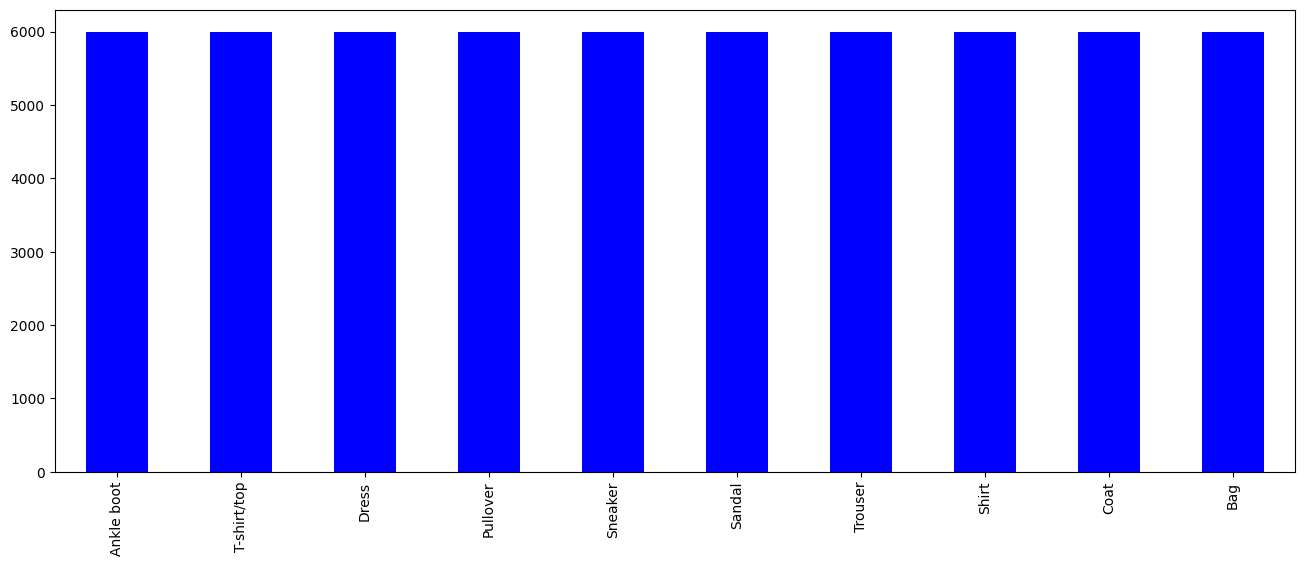

In [10]:
# plot a distribution data classnames
cnt_df=df_train.iloc[:,0].value_counts()
cnt_df.rename(class_names,axis=0).plot.bar(figsize=(16,6),color='b')

# Data Pipline Preprocessing
- Random horizontal flips
- Padding left/right 5px, top/bottom 6px
- Random cropping to 28x28 px
- Random square blackout region in img with hight, width being between: 28 x 0.15 <--> 28 x 0.60

In [4]:
def random_blackout(img, input_dim=(28, 28)):
    min_side = np.min(input_dim)
    high = np.round(min_side * .60)
    low = np.round(min_side * .15)
    # height, width
    h, w = np.random.randint(high=high, low=low, size=(2))

    # offsets top and left
    ofs_t = np.random.randint(high=input_dim[0]-h, low=0, size=1)[0]
    #ofs_t = 0
    ofs_l = np.random.randint(high=input_dim[1]-w, low=0, size=1)[0]
    #ofs_l = 0

    mask = np.ones(input_dim)

    mask[ofs_t:ofs_t+h,ofs_l:ofs_l+w] = 0

    return img * mask


In [5]:
class BlackoutTransform():
    def __init__(self):
        """
        """
        
    def __call__(self, img):
        img_dim = img.shape
        np_arr = img.view(28,28).numpy()
        np_arr = random_blackout(np_arr, np_arr.shape)
        return torch.FloatTensor(np_arr).view(img_dim)

In [6]:
class ReshapeTransform():
    def __init__(self, new_size):
        """
        :new_size: tuple
        """
        self.new_size = new_size

    def __call__(self, img):
        """Reshape an image
        :img: ex 1x28x28
        :returns: reshaped tensor
        """
        return torch.reshape(img, self.new_size)

In [7]:
t = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomVerticalFlip(p=0.5),
                        transforms.Pad((5,6)),
                        transforms.RandomCrop(size=28, padding_mode="reflect"),
                        #transforms.RandomCrop(size=28),
                        #transforms.RandomAffine([0,180], translate=None, scale=None, shear=None, resample=False, fillcolor=0),
                        # Resize random crop, then pad
                        #transforms.RandomResizedCrop(28, scale=(1.1, 1.3), ratio=(1.1, 1.5), interpolation=2),
                        transforms.ToTensor(),
                        BlackoutTransform(),
                        ReshapeTransform((1, 28, 28))
])

In [8]:
class CustomTensorDataset(torch.utils.data.TensorDataset):
    def __init__(self, *tensors, transforms=None):
        self.transform = transforms
        super().__init__(*tensors)
    
    def __getitem__(self, index):
        img, target = self.tensors[0][index], self.tensors[1][index]
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.uint8(img.view(28,28).numpy()), mode='L')
    
        if self.transform is not None:
            img = self.transform(img)
                
        return (img, target)

In [9]:
def exclude_class(inputs, lbls, class_lbl):
    indices = np.where(lbls != class_lbl)
    inputs = np.take(inputs, indices[0], axis=0)
    lbls = np.take(lbls, indices[0], axis=0)
    return inputs, lbls

In [10]:
# Train data
train_X = df_train.iloc[:,1:]
train_Y = df_train.iloc[:,:1]
# Test data
test_X = df_test.iloc[:,1:]
test_Y = df_test.iloc[:,:1]

train_X, train_Y = exclude_class(train_X, train_Y, 2)
test_X, test_Y = exclude_class(test_X, test_Y, 2)

# Normalize data to [0,1]
fmnist_train = torch.utils.data.TensorDataset(torch.FloatTensor(train_X.values/255).view(-1,1,28,28), torch.LongTensor(train_Y.values).view(-1))
fmnist_train = CustomTensorDataset(torch.FloatTensor(train_X.values), torch.LongTensor(train_Y.values).view(-1), transforms=t)
fmnist_test = torch.utils.data.TensorDataset(torch.FloatTensor(test_X.values/255).view(-1,1,28,28), torch.LongTensor(test_Y.values).view(-1))

# Inspecting data

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


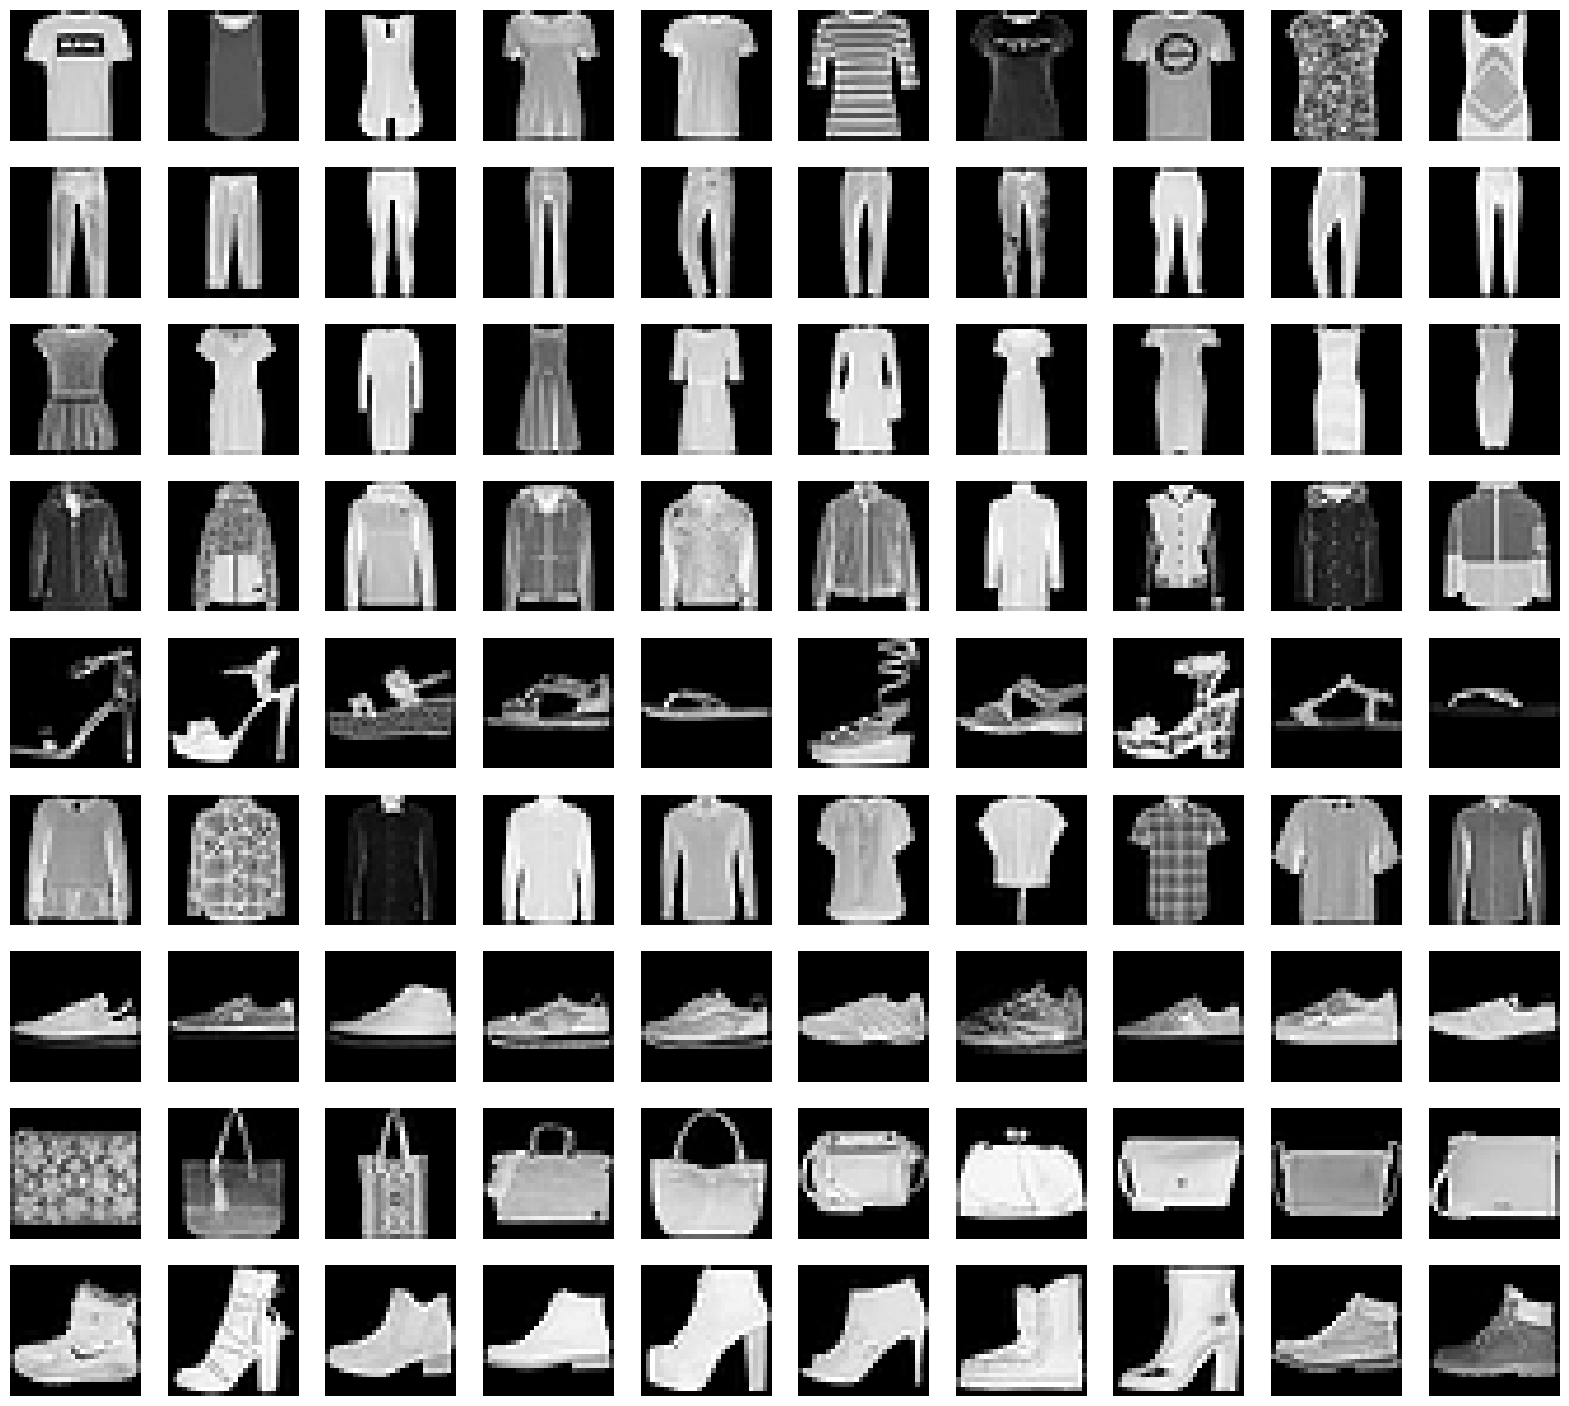

Preprocessed random 40:


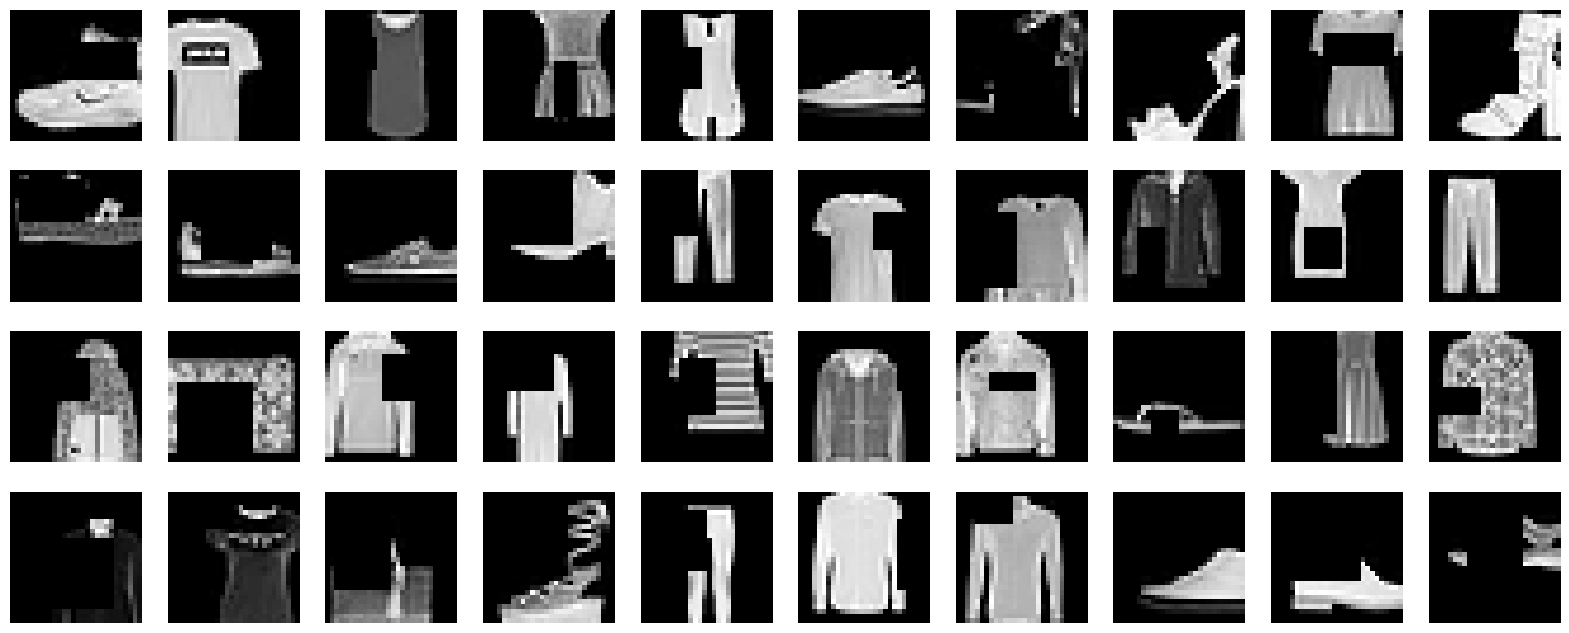

In [18]:
def show_images(images):
    n_images = len(images)
    w, h = 10, 10
    columns = 10
    rows = int(n_images / columns)
    fig=plt.figure(figsize=(columns*2, rows*2))
    for i in range(n_images):
        img = images[i].reshape(28,28)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()


examples = []
# Take 10 of each lbl class
for k in class_names.keys():
    indices = np.where(train_Y == k)
    images = np.take(train_X.values, indices[0][:10], axis=0)
    examples = examples + [x for x in images]
    
# examples = [x for x in examples for y in examples[]]

print(class_names)
show_images(examples)

print("Preprocessed random 40:")
examples = [fmnist_train[x][0] for x in range(40)]
show_images(examples)

In [11]:
# Create helper functions to resnet blocks
def conv1x1(in_planes, out_planes,stride=1):
    """1x1 convolutional"""
    return nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=1,bias=False)

def conv3x3(in_planes, out_planes,stride=1):
    """3x3 convolutional """
    return nn.Conv2d(in_planes,out_planes,kernel_size=3,stride=1,padding=1,bias=False)

In [12]:
class ResnetBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, dropout=0.18):
        super(ResnetBlock, self).__init__()
        # Conv layer 1
        self.conv_1 = conv3x3(in_planes, out_planes, stride)
        self.batch_norm_1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = dropout
        if self.dropout:
            self.dropout1 = nn.Dropout(p=dropout)
        # Conv layer 2
        self.conv_2 = conv3x3(out_planes, out_planes)
        self.batch_norm_2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        
        out = self.conv_1(x)
        # If no dropout then use batchnorm
        if not self.dropout:
            out = self.batch_norm_1(out)
        out = self.relu(out)
        
        # Use dropout in between
        if self.dropout:
            out = self.dropout1(out)
        
        out = self.conv_2(out)
        out = self.batch_norm_2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, k=1):
        super(ResNet, self).__init__()
        self.inplanes = 64
        # Convert to 64 channels
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)  # out bx64x28x28
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # out bx64x14x14
        self.layer1 = self._make_layer(block, 64*k, layers[0])  # out bx(64xk)x14x14
        self.layer2 = self._make_layer(block, 128*k, layers[1], stride=2)  # out bx(128xk)x7x7
        #self.layer3 = self._make_layer(block, 256*k, layers[2], stride=2)
        #self.layer4 = self._make_layer(block, 512*k, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # out bx(128*k)x1x1
        self.fc = nn.Linear(128*k * block.expansion, num_classes)  # out bx10

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                #nn.init.xavier_normal_(m.weight)
                
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        #x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

In [15]:
## Initialize model
model = ResNet(ResnetBlock, [2,2,2,2], k=2)

# Initialize linear layers
model.apply(init_weights)

# load pretrained state
model.to(device)
model.load_state_dict(torch.load("test_acc-706-epoch16.pth"))
# model.load_state_dict(torch.load("models\\training.pt"))

# Loss fn
criterion = nn.CrossEntropyLoss()

# optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-4, patience=8, verbose=True)

# only save model state if test acc is above "best_test_acc"
best_test_acc = 9560

# Use dramatic increased LR every x'th epoch (0 = None)
lr_inc_interval = 40

# Batch size
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=fmnist_train,
                                           batch_size=batch_size,
                                           pin_memory=True if use_cuda else False,
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=fmnist_test,
                                          batch_size=batch_size,
                                          pin_memory=True if use_cuda else False,
                                          shuffle=False)

# Cache train and testset size
train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)

In [30]:
# Used 800 epochs in both training steps
for epoch in range(75):
    # statistics
    train_loss = 0
    train_correct = 0
    test_correct = 0
    test_loss = 0
    time_start = time.time()
    # --

    if lr_inc_interval and not epoch % lr_inc_interval and epoch != 0:
        print("Increasing LR -- Big Steps")
        tmp_param_groups = optimizer.param_groups
        scheduler.num_bad_epochs -= 2
        for g in optimizer.param_groups:
            g['lr'] = 0.2
    else:
        tmp_param_groups = None

    model.train()
    for i, data in enumerate(train_loader):
        # inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the gradient
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # stats
        train_loss += loss
        train_correct += outputs.argmax(-1).eq(labels).sum()

    # Release unesecary memory
    if use_cuda:
        torch.cuda.empty_cache()
        
    # Sometimes take a huge step
    if tmp_param_groups:
        optimizer.param_groups = tmp_param_groups

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)

            # test loss
            test_loss += criterion(outputs, labels)

            # accuracy
            test_correct += outputs.argmax(-1).eq(labels).sum()
            

    test_loss = test_loss/test_size
    scheduler.step(test_loss)
    
    
    if test_correct > best_test_acc and test_correct > 9480:
        best_test_acc = test_correct
        print("Saving model")
        torch.save(model.state_dict(), 'test_acc-{}-epoch{}.pth'.format(test_correct, epoch))
    
    print("#{} {:.2f} seconds, \n  train: {}, {}/{}, test: {}, {}/{}".format(
        epoch+1, time.time() - time_start,
        train_loss/train_size,
        train_correct, train_size,
        test_loss,
        test_correct, test_size))

#1 521.14 seconds, 
  train: 0.0035675386898219585, 36424/54000, test: 0.002391307381913066, 7130/9000
#2 496.81 seconds, 
  train: 0.0021358057856559753, 43142/54000, test: 0.003214956959709525, 6769/9000
#3 494.34 seconds, 
  train: 0.0018316502682864666, 44684/54000, test: 0.0015724545810371637, 7721/9000
#4 514.66 seconds, 
  train: 0.001709103467874229, 45222/54000, test: 0.0017894814955070615, 7671/9000
#5 512.25 seconds, 
  train: 0.0015766920987516642, 45810/54000, test: 0.00147110631223768, 7758/9000
#6 512.27 seconds, 
  train: 0.0014803039375692606, 46211/54000, test: 0.0017727479571476579, 7694/9000
#7 506.25 seconds, 
  train: 0.0014189123176038265, 46635/54000, test: 0.001372792525216937, 7817/9000
#8 510.16 seconds, 
  train: 0.0013786606723442674, 46759/54000, test: 0.0011268781963735819, 8066/9000
#9 516.32 seconds, 
  train: 0.0013287868350744247, 46984/54000, test: 0.0010210906621068716, 8141/9000
#10 502.91 seconds, 
  train: 0.0012970103416591883, 47205/54000, test

KeyboardInterrupt: 

In [31]:
torch.save(model.state_dict(), 'test_acc-{}-epoch{}.pth'.format(test_correct, epoch))

In [30]:
model = ResNet(ResnetBlock, [2,2,2,2], k=2)
model.load_state_dict(torch.load("test_acc-706-epoch16.pth"))
model = model.to(device)

In [31]:
total_wrong_labels = torch.LongTensor().cuda()
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)

        # correct
        test_correct = outputs.argmax(-1).eq(labels)
        wrong_labels = labels[test_correct == 0]
        total_wrong_labels = torch.cat((total_wrong_labels, wrong_labels))

d:\MBKM\Start up campus\Final Projeck\Fashion_Mnist\env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [32]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [33]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [34]:
# Calculate model 1 results with device-agnostic code 
# Import accuracy metric
from helper_functions import accuracy_fn
model_results = eval_model(model=model, data_loader=test_loader,
    loss_fn=criterion, accuracy_fn=accuracy_fn,
    device=device
)
model_results

{'model_name': 'ResNet',
 'model_loss': 0.24464626610279083,
 'model_acc': 90.46440972222223}

In [35]:
t_np = total_wrong_labels.cpu().numpy()
t_np

array([4, 9, 4, 0, 3, 3, 6, 3, 7, 4, 9, 0, 9, 6, 4, 4, 0, 4, 0, 4, 3, 0,
       9, 4, 4, 0, 4, 4, 0, 4, 9, 6, 0, 0, 3, 3, 4, 0, 4, 3, 3, 7, 3, 0,
       6, 0, 3, 4, 0, 0, 4, 3, 4, 4, 6, 0, 5, 0, 7, 1, 7, 4, 4, 0, 4, 0,
       6, 7, 4, 0, 0, 3, 0, 3, 4, 0, 0, 4, 4, 5, 4, 4, 4, 0, 0, 4, 6, 0,
       4, 0, 4, 4, 4, 7, 7, 6, 0, 4, 7, 0, 6, 0, 4, 0, 0, 4, 3, 4, 0, 4,
       4, 4, 0, 4, 4, 9, 1, 4, 0, 5, 9, 6, 0, 0, 0, 5, 4, 9, 6, 6, 6, 6,
       3, 0, 3, 4, 0, 0, 0, 6, 6, 0, 4, 3, 4, 7, 5, 3, 0, 3, 3, 8, 4, 3,
       4, 0, 0, 4, 0, 0, 4, 7, 3, 7, 6, 5, 9, 3, 0, 0, 4, 7, 4, 3, 4, 3,
       4, 7, 7, 4, 3, 6, 4, 0, 5, 0, 4, 0, 4, 0, 0, 3, 6, 0, 0, 4, 1, 6,
       4, 3, 4, 6, 0, 6, 4, 0, 3, 4, 0, 0, 6, 6, 7, 0, 4, 6, 0, 4, 9, 7,
       0, 7, 4, 4, 0, 0, 0, 4, 4, 3, 3, 0, 3, 3, 1, 3, 0, 4, 4, 4, 0, 7,
       3, 3, 0, 0, 6, 4, 3, 4, 0, 3, 4, 8, 0, 7, 3, 4, 0, 6, 1, 0, 7, 6,
       3, 7, 8, 3, 6, 3, 3, 4, 4, 4, 0, 0, 3, 0, 3, 3, 4, 4, 4, 6, 0, 3,
       4, 4, 0, 0, 7, 6, 3, 7, 0, 0, 7, 3, 3, 8, 0,

T-shirt/top: 253
Trouser: 19
Dress: 113
Coat: 225
Sandal: 15
Shirt: 116
Sneaker: 77
Bag: 13
Ankle boot: 37
Total wrong classifications: 868/9000


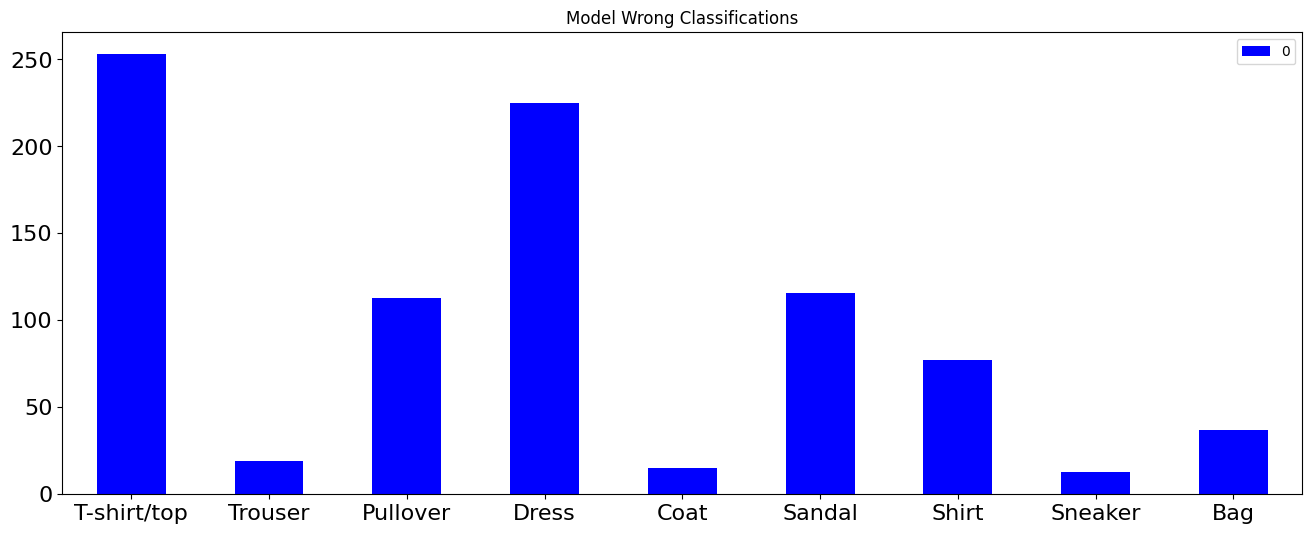

In [37]:
lbl_counts = np.unique(t_np, return_counts=True)

lbls, counts = lbl_counts
for idx, lbl in enumerate(lbls):
    try:
        print("{}: {}".format(class_names[lbl], counts[idx]))
    except:
        print("{} is excluded.".format(class_names[lbl]))
        
df_wrong = pd.DataFrame(counts).rename(class_names, axis='index')
ax = df_wrong.plot.bar(figsize=(16,6), color="b", title="Model Wrong Classifications", fontsize=16, rot=0)

print("Total wrong classifications: {}/{}".format(counts.sum(), len(fmnist_test)))

### Test order dataset

In [16]:
import tensorflow
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
import numpy as np
from numpy.linalg import norm
import os
from tqdm import tqdm
import pickle 

In [17]:
import tensorflow as tf
if tf.test.gpu_device_name():
      print(f'Default GPU Device:{tf.test.gpu_device_name()}')
else:
      print("Please check your installation")

Default GPU Device:/device:GPU:0


In [18]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array,axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

In [20]:
# Load model
from resnet import conv1x1,conv3x3,ResnetBlock,ResNet
model = ResNet(ResnetBlock, [2,2,2,2], k=2)
model.load_state_dict(torch.load("test_acc-706-epoch16.pth"))
model = model.to(device)

In [44]:
data[0][:10]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [73]:
test_labels=data[1][:9]
test_samples = data[0][:9]

In [74]:
# Make predictions on test samples with model 0
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs

tensor([[1.7058e-01, 1.7024e-07, 4.8802e-09, 1.3979e-04, 1.7001e-04, 2.5012e-09,
         8.2910e-01, 2.0234e-09, 6.9061e-06, 7.5542e-08],
        [9.9267e-01, 5.6009e-08, 2.2107e-10, 1.0044e-04, 2.0114e-07, 1.0118e-10,
         7.2270e-03, 4.1867e-11, 1.6740e-07, 3.5457e-09],
        [2.7662e-06, 7.9860e-07, 7.6146e-10, 9.1389e-07, 9.8809e-01, 7.7300e-09,
         1.1860e-02, 6.3740e-08, 4.3872e-05, 9.3748e-07],
        [1.0104e-07, 1.0000e+00, 6.1452e-13, 7.3043e-08, 2.2919e-09, 1.0129e-10,
         7.2216e-08, 1.1017e-13, 2.9618e-11, 3.3460e-10],
        [2.7163e-03, 3.2454e-04, 2.9472e-06, 2.4762e-03, 9.6598e-02, 4.3859e-04,
         7.4307e-01, 1.2787e-05, 1.5342e-01, 9.4002e-04],
        [1.9763e-04, 1.7454e-08, 7.7503e-11, 1.1527e-05, 9.1932e-05, 2.1105e-10,
         9.9970e-01, 2.3678e-11, 8.0298e-08, 5.0013e-09],
        [3.0100e-05, 4.5343e-06, 2.1282e-09, 2.3753e-04, 8.5548e-01, 2.2635e-10,
         1.4425e-01, 5.4665e-10, 6.1166e-08, 1.6693e-08],
        [1.7377e-07, 3.3140

In [75]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([6, 0, 4, 1, 6, 6, 4, 9, 1])

In [76]:
pred_classes, test_labels

(tensor([6, 0, 4, 1, 6, 6, 4, 9, 1]), tensor([6, 0, 4, 1, 6, 6, 4, 9, 1]))

In [77]:
y_class =['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [78]:
y_class[pred_classes[0]]

'Shirt'

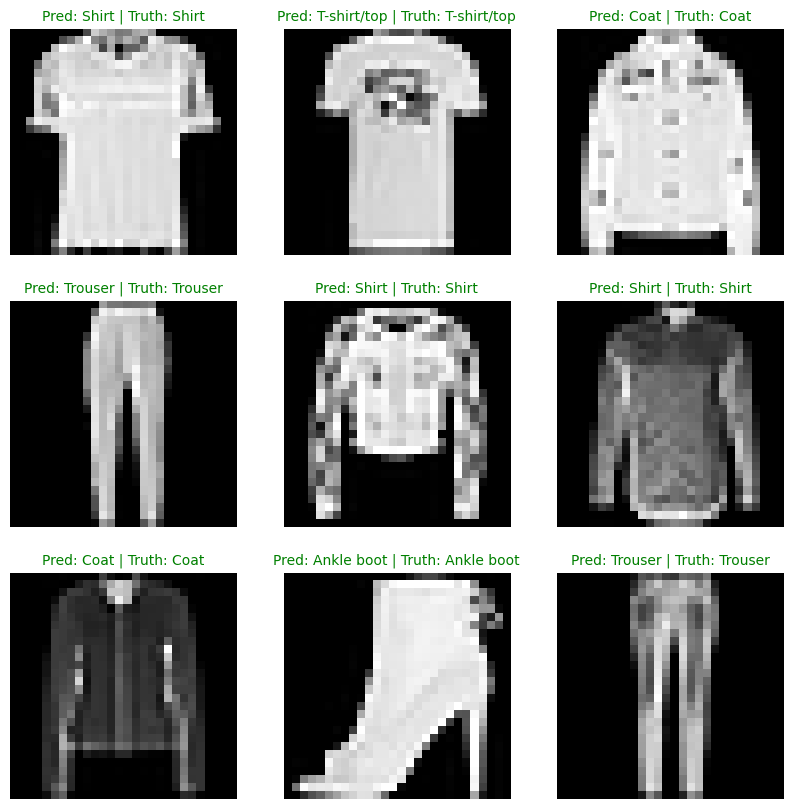

In [79]:
# Plot predictions
plt.figure(figsize=(10,10 ))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = y_class[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = y_class[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)